In [1]:
import numpy as np
import pandas as pd
import iminuit
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
sns.set(rc={'figure.figsize':(16,10)})
plt.style.use('seaborn-whitegrid')

plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['figure.titlesize'] = 18

In [3]:
class MDVM():
    def __init__(self):
        self.ALPHA = 7.297e-3
        self.C = 0.389379292e12 #(MeV)^2 * nb

        self.mPhi = 1019.464
        self.mRho = 775.26
        self.mOmg = 782.65

        self.mK0 = 497.6
        self.mP0 = 135.
        self.mKC = 493.677
        self.mPC = 139.57

        self.w0Phi = 4.247
        self.w0Rho = 147.8
        self.w0Omg = 8.49
    
    def BETA(self, s, M_K): #бета
        E = np.sqrt(s)/2.
        P = np.sqrt( E**2 - M_K**2 )
        return P/E
    def PV2(self, s, M, Mn): #фазовый объём распада на 2 одинаковые частицы
        E = np.sqrt(s)/2.
        w = np.where(s <= 4*Mn*Mn, 0, np.power( (s/4. - Mn**2)/((M**2)/4. - Mn**2), 3./2 )*(M**2)/s )
        return w
    def PV3(self, s, MX, m1, m2, m3): #фазовый объём (почти: он типа нормирован) распада на 3 частицы
        #WARNING. TRY TO FIND THE RIGHT VARIANT
        pv = (np.sqrt(s) - m1 - m2 - m3)**2
        pv0 = (np.sqrt(MX*MX) - m1 - m2 - m3)**2
        return pv/pv0
    def PVG(self, s, M, Mn): #распад частицы M на фотон и частицу Mn
        pv  = ((s - Mn**2)/(2*np.sqrt(s)))**3
        pv0 = ((MX**2 - Mn**2)/(2*MX))**3
        return pv/pv0
    
    def WOmg(self, s, W0, MX):    
        Br_3Pi = 0.892    
        Br_Pi0G = 0.084
        Br_2Pi = 0.0153
        ost = 1 - Br_Pi0G - Br_2Pi;
        
        mPC = self.mPC
        mP0 = self.mP0

        W = W0 * ((Br_3Pi + ost) * PV3(s, MX, mPC, mPC, mP0) + \
                  Br_Pi0G * PVG(s, MX, mP0) + Br_2Pi * PV2(s, MX, mPC));
        return W
    def WPhi(self, s, W0, MX):
        Br_KC = 0.492
        Br_KN = 0.34
        Br_3Pi = 0.1524
        Br_EG = 0.01303
        ost = 1 - Br_KC - Br_KN - Br_3Pi - Br_EG

        mEta = 547.862
        mKC = self.mKC
        mK0 = self.mK0
        mPC = self.mPC
        mP0 = self.mP0

        W = W0*((Br_KC + ost)*PV2(s, MX, mKC) + Br_KN*PV2(s, MX, mK0) + \
                Br_3Pi * PV3(s, MX, mPC, mPC, mP0) + Br_EG * PVG(s, MX, mEta));
        return W
    
    def WRhoX(self, s, W0, MX):
        return W0 * self.PV2(s, MX, self.mPC)
    def WOmgX(self, s, W0, MX):
        return W0 * self.PV3(s, MX, self.mPC, self.mPC, self.mP0)
    def WPhiX(self, s, W0, MX):
        return W0 * self.PV2(s, MX, self.mKC)
    
    def BW(self, s, MX, WX0, WX): #функция Брейта-Вигнера
        bw = (MX**2)/( MX**2 - s - 1j*np.sqrt(s)*WX(s, WX0, MX) )
        return bw
    def BW_RhoX(self, s, mX, wX):
        return self.BW(s, mX, wX, self.WRhoX)
    def BW_OmgX(self, s, mX, wX):
        return self.BW(s, mX, wX, self.WOmgX)
    def BW_PhiX(self, s, mX, wX):
        return self.BW(s, mX, wX, self.WPhiX)
    
    def BW_Rho(self, s):
        return self.BW_RhoX(s, self.mRho, self.w0Rho)
    def BW_Omg(self, s):
        return self.BW_OmgX(s, self.mOmg, self.w0Omg)
    def BW_Phi(self, s):
        return self.BW_PhiX(s, self.mPhi, self.w0Phi)
    def BW_Rho1(self, s):
        return self.BW_RhoX(s, 1490, 340)
    def BW_Omg1(self, s):
        return self.BW_OmgX(s, 1420, 220)
    def BW_Rho2(self, s):
        return self.BW_RhoX(s, 1574, 234)
    def BW_Omg2(self, s):
        return self.BW_OmgX(s, 1688, 350)
    def BW_Phi1(self, s):
        return self.BW_PhiX(s, 1673, 182)
    def BW_Rho3(self, s): #unused
        return self.BW_RhoX(s, 1720, 250)
    def BW_Rho4(self, s): #unused
        return self.BW_RhoX(s, 1880, 160)
    def BW_Rho5(self, s):
        return self.BW_RhoX(s, 2134, 343)
    def BW_Phi2(self, s):
        return self.BW_PhiX(s, 2198, 71)
    
    #PUBLIC
    def F0(self, x, par, mode=False): #формфактор, нулевое приближение; mode: 0 - short/long; 1 - charged;
        n = par[10] #1.027
        s = (x*1e3)**2
        
        CR = par[0]
        CO = par[1]
        CP = par[2]
        
        KR = CR/2. if mode else -CR/2.
        KO = CO/6.
        KP = CP/3. if mode else n*CP/3.
        
        F = KR * self.BW_Rho(s) + KO * self.BW_Omg(s) + KP * self.BW_Phi(s)
        return F
    def F1(self, x, par, mode=False): #формфактор с учётом omega(1400)
        s = (x*1e3)**2
        
        CR = np.array([par[0], par[3], par[6], par[8]]) # , 1-par[0]-par[3]-par[6] ]
        CO = np.array([par[1], par[4], par[7], par[8]]) # , 1-par[0]-par[3]-par[6] ]
        CP = np.array([par[2], par[5], par[9]])         # , 1-par[2]-par[5], 0 ]
        
        KR = CR/2. if mode else -CR/2.
        KO = CO/6.
        KP = CP/3. #здесь уже нет дополнительного параметра n, как в F0 (в соотв. с моделью)
        
        F1 = self.F0(x, par, mode)
        
        F1 += KR[1] * self.BW_Rho1(s) + KR[2] * self.BW_Rho2(s) + KR[3] * self.BW_Rho5(s)
        F1 += KO[1] * self.BW_Omg1(s) + KO[2] * self.BW_Omg2(s) + KO[3] * self.BW_Rho5(s)
        F1 += KP[1] * self.BW_Phi1(s) + KP[2] * self.BW_Phi2(s)
        return F1
        
    def Cross_Section(self, x, par, mode=False):
        s = (x*1e3)**2
        fabs2 = np.abs( self.F1(x, par, mode) )**2
        M_K = self.mKC if mode else self.mK0
        constant = (np.pi/3.) * (self.ALPHA**2) * self.C
        cs = np.where( x<0.4976*2, 0, constant * (self.BETA(s, M_K)**3) * fabs2 / s  )
        return cs
    def Cross_Section_Neutral(self, x, par):
        return self.Cross_Section(x, par, False)
    def Cross_Section_Charged(self, x, par):
        return self.Cross_Section(x, par, True)
    

Получаю данные

In [4]:
#KSKL на phi(1020)
cs_k0k0_phi = pd.read_csv('../formfactor/data/k0k0_koz.dat', delimiter='\t', \
                          names=['index', 'energy', 'energy_err', 'cs', 'cs_err'])
cs_k0k0_phi['energy'] *= 1e-3
cs_k0k0_phi['energy_err'] *= 1e-3
cs_k0k0_phi['cs_err'] = np.sqrt( cs_k0k0_phi.cs_err**2 + (0.018*cs_k0k0_phi.cs)**2 ) #учёт систематики: 1.8% из статьи
cs_k0k0_phi.drop('index', axis=1, inplace=True)

In [5]:
#K+K- на phi(1020)
cs_kpkm_phi = pd.read_csv('../formfactor/data/k+k-_koz.dat', delimiter='\t', \
                          names=['energy', 'energy_err', 'cs', 'cs_err'])
cs_kpkm_phi['energy'] *= 1e-3
cs_kpkm_phi['cs_err'] = np.sqrt( cs_kpkm_phi.cs_err**2 + (0.02*cs_kpkm_phi.cs)**2 )#учёт систематики: мин.2% из статьи
cs_kpkm_phi['energy_err'] *= 1e-3

In [6]:
#K+K- на больших энергиях
cs_kpkm = pd.read_csv('../formfactor/data/k+k-.dat', \
                          names=['energy', 'cs', 'stat', 'syst'])
cs_kpkm['cs_err'] = np.sqrt(cs_kpkm.stat**2 + cs_kpkm.syst**2)
cs_kpkm.drop(['stat','syst'], axis=1, inplace=True)

In [35]:
#KSKL
kskl11 = pd.read_csv('../outputs/11/result_new.csv')
kskl12 = pd.read_csv('../outputs/12/result_new.csv')
kskl17 = pd.read_csv('../outputs/17/result_new.csv')
kskl19 = pd.read_csv('../outputs/19/result_new.csv')
radcors = pd.read_csv('../outputs/radcors.dat', names=['energy', 'radcor'])
#                      names=['ff', 'energy', 'de1', 'de2', 'e_err', 'cs', 'cs_err'])
cs_kskl = pd.concat([kskl11, kskl12, kskl17, kskl19], sort=False)
cs_kskl.drop(['Unnamed: 0', 'dEmax', 'dEmin', 'err', 'lum_err'], axis=1, inplace=True)
cs_kskl.columns = ['energy', 'cs', 'cs_err']
cs_kskl['energy'] *= 2e-3

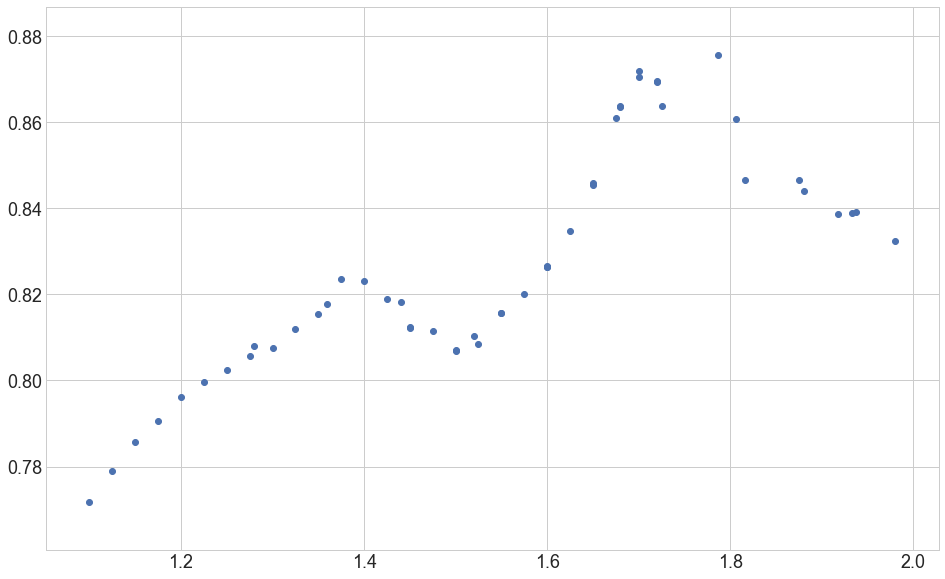

In [36]:
plt.scatter(radcors.energy, radcors.radcor)

In [37]:
cs_kskl['rad'] = np.interp(cs_kskl.energy, radcors.energy, radcors.radcor)
cs_kskl['cs'] /= cs_kskl.rad
cs_kskl['cs_err'] /= cs_kskl.rad

In [38]:
cs_kskl.head()

,energy,cs,cs_err,rad
0,1.04716,19.000164,1.126427,0.771796
1,1.07482,9.611451,0.428191,0.771796
2,1.09688,6.073645,0.436840,0.771796
3,1.12426,4.339983,0.265860,0.778821
4,1.15062,2.537948,0.265254,0.785705


Определяю loss function

In [39]:
A = MDVM()

In [40]:
def least_squares(par):
    pred1 = np.square( (cs_k0k0_phi.cs - A.Cross_Section_Neutral(cs_k0k0_phi.energy, par))/cs_k0k0_phi.cs_err ).sum()
    pred2 = np.square( (cs_kpkm_phi.cs - A.Cross_Section_Charged(cs_kpkm_phi.energy, par))/cs_kpkm_phi.cs_err ).sum()
    pred3 = np.square( (cs_kpkm.cs - A.Cross_Section_Charged(cs_kpkm.energy, par))/cs_kpkm.cs_err ).sum()
    pred4 = 10*np.square( (cs_kskl.cs - A.Cross_Section_Neutral(cs_kskl.energy, par))/cs_kskl.cs_err ).sum()
    
    chisq = pred1 + pred2 + pred3 + pred4
    return chisq

In [41]:
names = ['$\\rho$', '$\\omega$', '$\\phi$', '$\\rho\'$', '$\\omega\'$', 
         '$\\phi\'$', '$\\rho\'\'$', '$\\omega\'\'$', '$\\rho\'\'\'$', '$\\phi\'\'$', '$\\eta$']
#params = [1.531, 1.98, 1.036, -0.165, -0.04, -0.114, -0.032, -0.105, 0.1, 0.1, 0.990]
params = [1.4307, 2.0074, 1.031, 0.1468, -0.2322, -0.3822, -0.2271, 0.7912, 0.0443, 0.1174, 0.9977]
fix_pars = [False, False, False, False, False, False, False, False, False, False, False] # True False
error_pars = 0.05*np.array(params)

In [42]:
print(list(m.np_values().round(4)))

[1.5886, 2.1845, 1.0279, 0.1852, -0.2421, -0.5337, -0.2317, 1.2961, 0.0609, 0.0354, 1.0194]


In [43]:
m = iminuit.Minuit.from_array_func(least_squares, params, fix=fix_pars, name=names, \
                                   error=error_pars, errordef=1)
m.get_param_states()

------------------------------------------------------------------------------------------------
|   | Name       |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------------
| 0 | $\rho$     |   1.43    |   0.07    |            |            |         |         |       |
| 1 | $\omega$   |   2.01    |   0.10    |            |            |         |         |       |
| 2 | $\phi$     |   1.03    |   0.05    |            |            |         |         |       |
| 3 | $\rho'$    |   0.147   |   0.007   |            |            |         |         |       |
| 4 | $\omega'$  |  -0.232   |  -0.012   |            |            |         |         |       |
| 5 | $\phi'$    |  -0.382   |  -0.019   |            |            |         |         |       |
| 6 | $\rho''$   |  -0.227   |  -0.011   |            |            |         |         |       |
| 7 | $\omega''$ |   0.79    |   0.04    |            |            |         |         |       |
| 8 | $\rho'''$  | 0.443E-1  | 0.022E-1  |            |            |         |         |       |
| 9 | $\phi''$   |   0.117   |   0.006   |            |            |         |         |       |
| 10| $\eta$     |   1.00    |   0.05    |            |            |         |         |       |
------------------------------------------------------------------------------------------------

In [ ]:
m.migrad()

Plotting

In [29]:
box_1 = {'facecolor':'black', 'boxstyle': 'round'}

In [30]:
params = m.np_values()

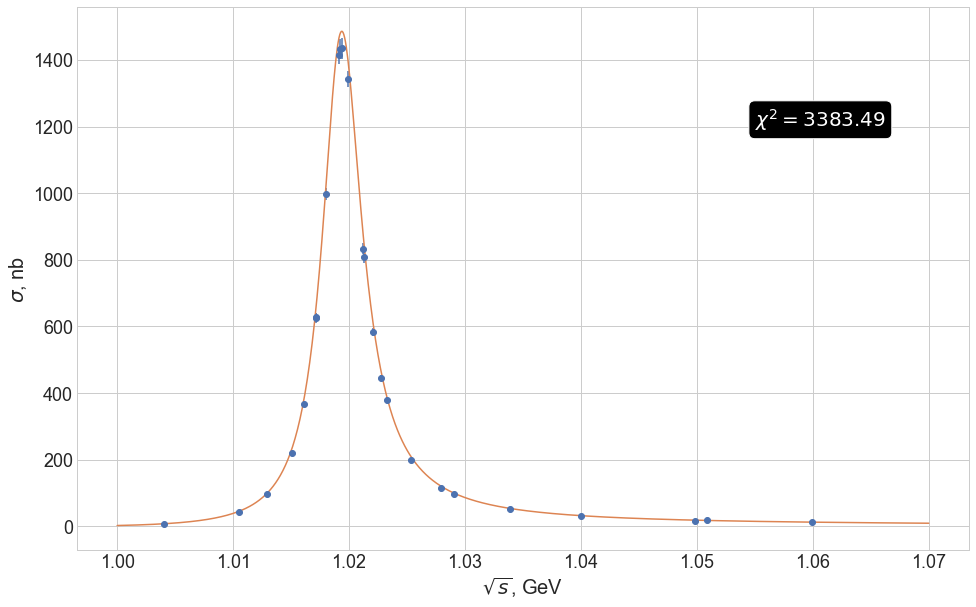

In [31]:
#Fitting line
plt.errorbar(data=cs_k0k0_phi, x='energy', y='cs', xerr='energy_err', yerr='cs_err', fmt='o')

#Experimental points
x_k0k0_phi = np.linspace(1., 1.07, 1000)
plt.plot(x_k0k0_phi, A.Cross_Section_Neutral(x_k0k0_phi, params) )

#Text and labels
plt.xlabel('$\sqrt{s}$, GeV', fontsize=20)
plt.ylabel('$\sigma$, nb', fontsize=20)
ax = plt.gca()
text_label = f"$\chi^2 = {least_squares(params):.2f}$"
ax.text(1.055, 1200, text_label, bbox=box_1, color='white', fontsize=20)
ax.tick_params(labelsize=18);

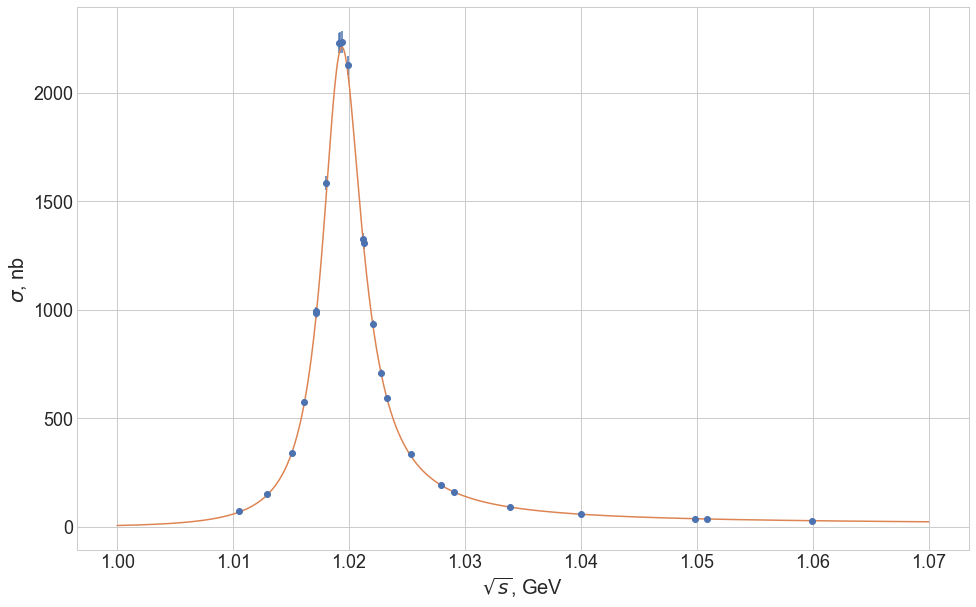

In [32]:
plt.errorbar(data=cs_kpkm_phi, x='energy', y='cs', xerr='energy_err', yerr='cs_err', fmt='o')

x_kpkm_phi = np.linspace(1., 1.07, 1000)
plt.plot(x_k0k0_phi, A.Cross_Section_Charged(x_kpkm_phi, params) )

ax = plt.gca()
plt.xlabel('$\sqrt{s}$, GeV');
plt.ylabel('$\sigma$, nb');

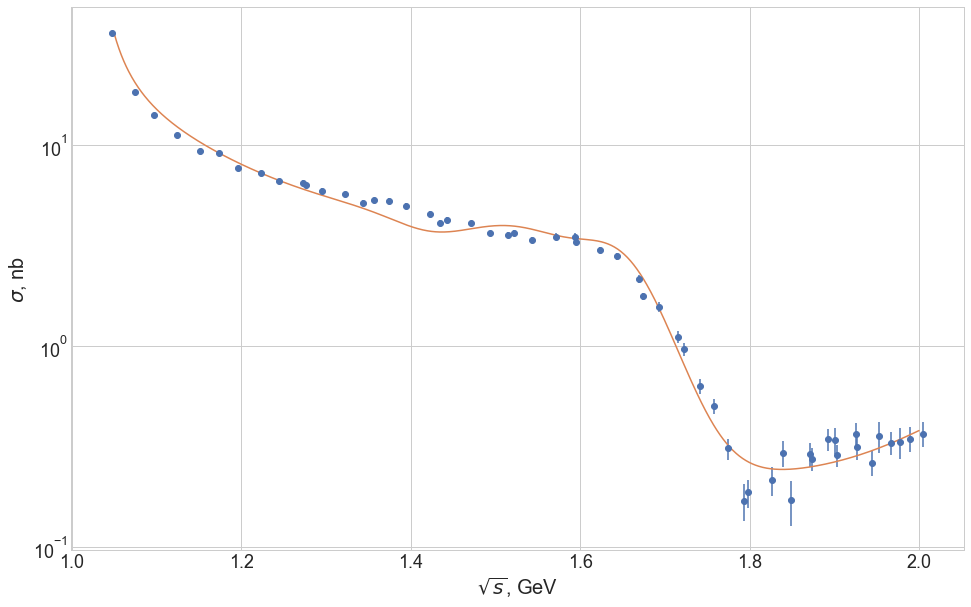

In [33]:
plt.errorbar(data=cs_kpkm, x='energy', y='cs', yerr='cs_err', fmt='o')

x_kpkm = np.linspace(1.05, 2., 1000)
plt.plot(x_kpkm, A.Cross_Section_Charged(x_kpkm, params) )
plt.yscale('log')

ax = plt.gca()
plt.xlabel('$\sqrt{s}$, GeV');
plt.ylabel('$\sigma$, nb');

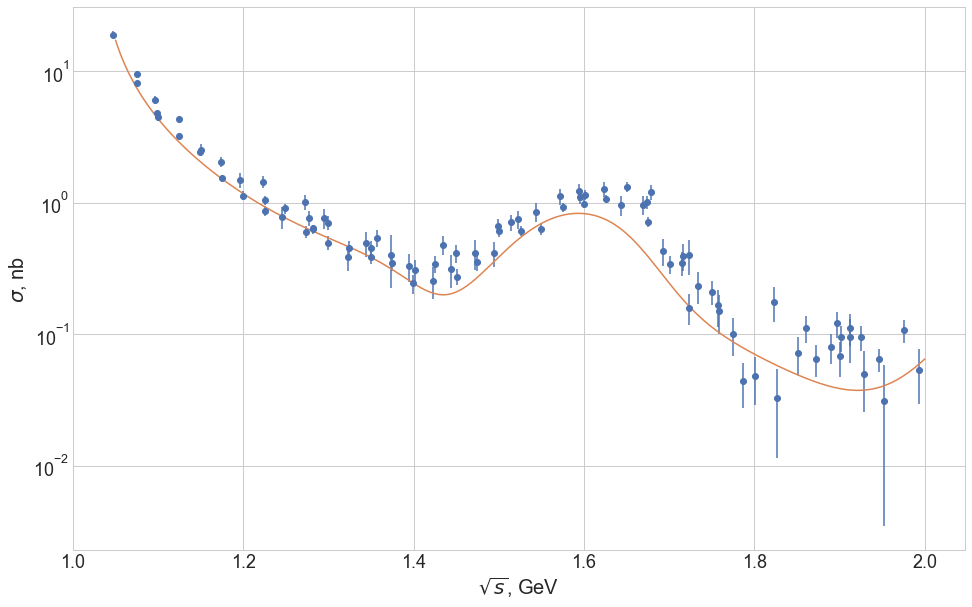

In [44]:
plt.errorbar(data=cs_kskl, x='energy', y='cs', yerr='cs_err', fmt='o')

x_kskl = np.linspace(1.05, 2., 1000)
plt.plot(x_kskl, A.Cross_Section_Neutral(x_kskl, params) )
plt.yscale('log')

ax = plt.gca()
plt.xlabel('$\sqrt{s}$, GeV');
plt.ylabel('$\sigma$, nb');

Save fitting cross section

In [91]:
df_crosssec = pd.DataFrame()

In [92]:
df_crosssec['x'] = np.linspace(1.0, 2.01, 2000)
df_crosssec['c'] = A.Cross_Section_Neutral(df_crosssec.x, params).round(3)

In [93]:
df_crosssec['x'] = (df_crosssec.x*1e3).round(2)

In [94]:
np.savetxt('../inputs/radcors/cs.dat', df_crosssec, delimiter=' ', fmt='%.2f')

In [95]:
df_crosssec

,x,c
0,1000.00,1.798
1,1000.51,2.191
2,1001.01,2.637
3,1001.52,3.143
4,1002.02,3.717
...,...,...
1995,2007.98,0.073
1996,2008.48,0.073
1997,2008.99,0.074
1998,2009.49,0.074


Calculate new rad corrections

In [ ]:
%%bash
cd 
source programs/root/bin/thisroot.sh
cd ~/projects/ROOT/research/code
root -l radcors.cpp